# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

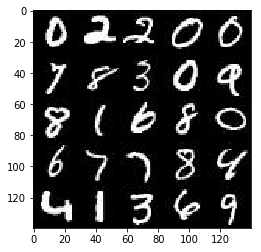

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

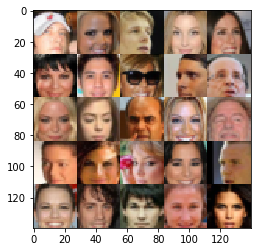

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, shape=(None,
                                                  image_width,
                                                  image_height,
                                                  image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None,
                                               z_dim))
    
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

        saver.save(sess, './generator.ckpt')
    
    return losses
      
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 5.9119
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 4.7899
Epoch 1/2... Discriminator Loss: 0.8644... Generator Loss: 4.1131
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 5.8512
Epoch 1/2... Discriminator Loss: 0.3408... Generator Loss: 5.6261
Epoch 1/2... Discriminator Loss: 0.4866... Generator Loss: 4.9269
Epoch 1/2... Discriminator Loss: 0.3588... Generator Loss: 6.8522
Epoch 1/2... Discriminator Loss: 0.3511... Generator Loss: 4.6173
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 1.6670
Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 2.0912


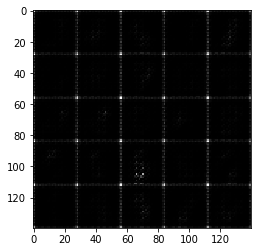

Epoch 1/2... Discriminator Loss: 0.5109... Generator Loss: 2.6686
Epoch 1/2... Discriminator Loss: 1.6620... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.8383


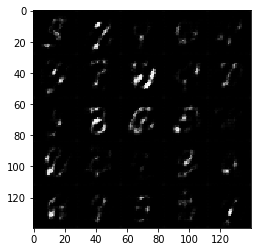

Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 1.4575
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.0927... Generator Loss: 1.4736
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.8396
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 1.1980
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.1107
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.7151


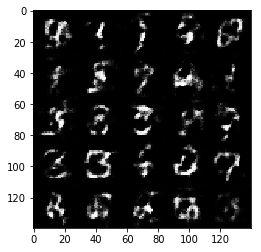

Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 1.0363
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.4068
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 1.5504
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 1.6476... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 0.7872


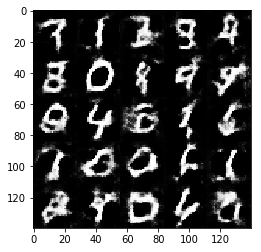

Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 0.7754
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 1.2384
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.0642
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 1.3336
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 0.8656


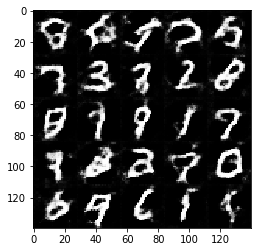

Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 1.1112
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 1.1830
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 1.3713
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.6893


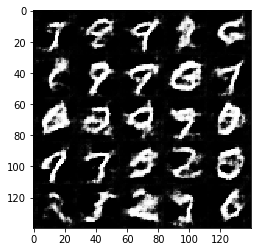

Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 1.7790
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 2.1429
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 1.2881
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.8764
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.9860


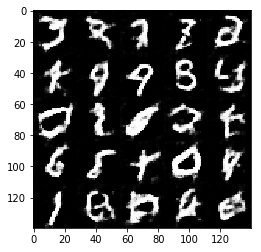

Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 1.7089
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 1.0661
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 0.4298
Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 1.5367
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.2351
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.8302


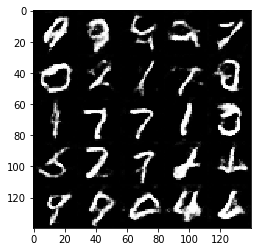

Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.5194
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 0.9070... Generator Loss: 1.1929
Epoch 1/2... Discriminator Loss: 2.0189... Generator Loss: 3.0665
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.4854
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 0.9561


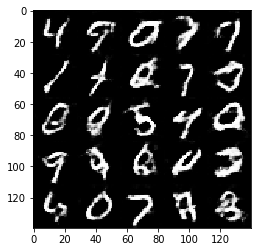

Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.5104
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 1.0965
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 2.3466
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.7083
Epoch 2/2... Discriminator Loss: 1.6507... Generator Loss: 0.5134


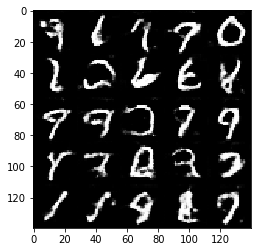

Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.6600
Epoch 2/2... Discriminator Loss: 2.0107... Generator Loss: 0.2765
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 1.0521
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.6670


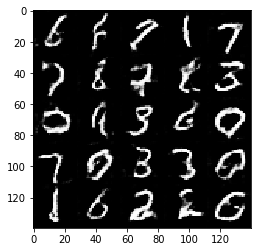

Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 1.0895
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 0.9521... Generator Loss: 1.7861
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 1.0398
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 0.9491
Epoch 2/2... Discriminator Loss: 1.5368... Generator Loss: 0.5410
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 1.4321


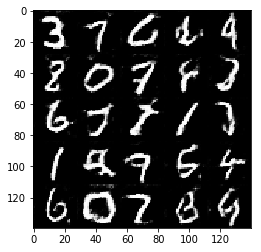

Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 1.4110
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.0963
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.6270
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.5932
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 1.6472
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.8115
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.5207


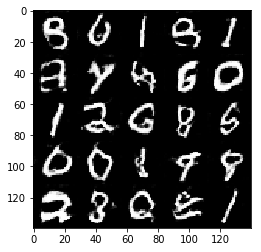

Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 1.1948
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.2959
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 1.6207
Epoch 2/2... Discriminator Loss: 1.1248... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 1.3184
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 2.3027
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.5022
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 2.2703
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 1.3747


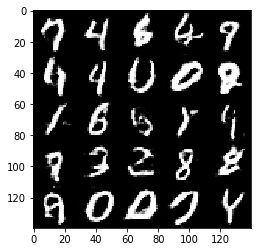

Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.5012
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.3626
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.8170
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 1.0743... Generator Loss: 1.1081
Epoch 2/2... Discriminator Loss: 0.9735... Generator Loss: 0.9263
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 1.1905
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.1705


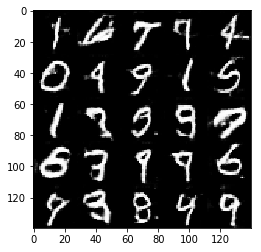

Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.6058
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 2.0014
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 1.4927
Epoch 2/2... Discriminator Loss: 1.0181... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 1.2276


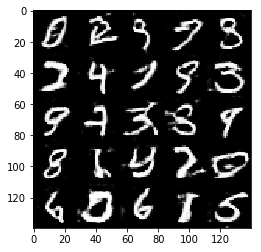

Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 1.0716
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.7250
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.1153
Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 1.9590
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.2897
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.3208
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 1.5179
Epoch 2/2... Discriminator Loss: 1.6628... Generator Loss: 0.3628
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 1.7537


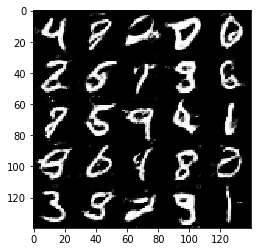

Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 0.9720
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 1.2649
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.1857
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 1.1359
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 1.7107
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.5674
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.5946
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 0.9861


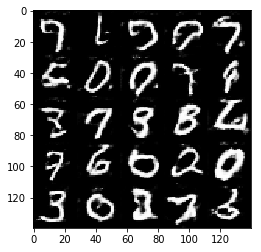

Epoch 2/2... Discriminator Loss: 1.0117... Generator Loss: 1.2059
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.3953
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.0419


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 3.5347
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 8.4996
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 4.1981
Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 6.1026
Epoch 1/1... Discriminator Loss: 2.4936... Generator Loss: 0.2346
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 2.4178
Epoch 1/1... Discriminator Loss: 1.9183... Generator Loss: 3.4986
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 2.6959
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 3.5885


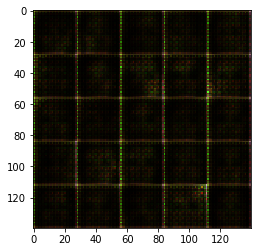

Epoch 1/1... Discriminator Loss: 3.1974... Generator Loss: 0.0877
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.9237
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 2.8659
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.5586
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 1.7293
Epoch 1/1... Discriminator Loss: 1.7628... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 2.4068


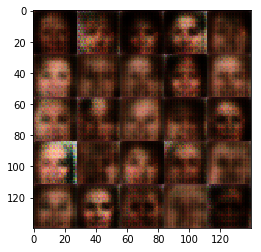

Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 2.0647... Generator Loss: 0.2786
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.8281
Epoch 1/1... Discriminator Loss: 2.8244... Generator Loss: 0.1123
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 1.4011


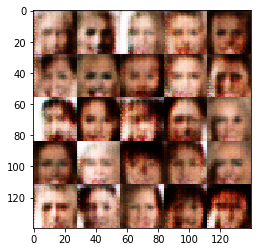

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.9229


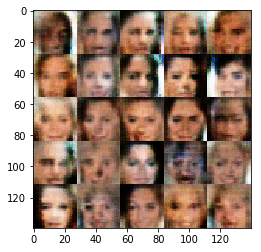

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.9820... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 1.7350... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.7993
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.6823


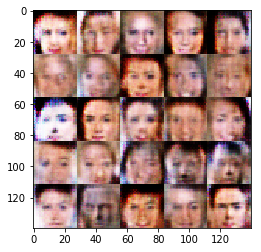

Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.7386
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 1.7310
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 2.2762
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 2.6862


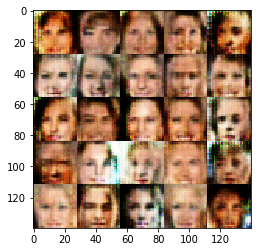

Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.8691
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.8078


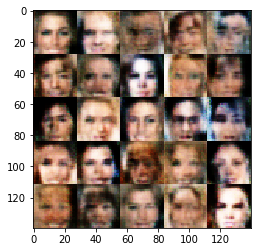

Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 2.2491
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 1.6167... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.8640


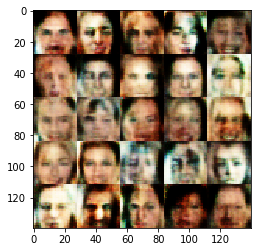

Epoch 1/1... Discriminator Loss: 1.7089... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0169


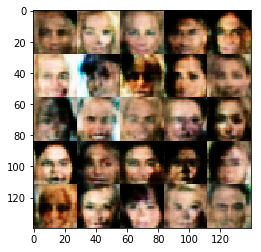

Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.1879


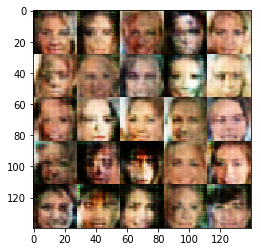

Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.3563
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 2.0267
Epoch 1/1... Discriminator Loss: 2.1501... Generator Loss: 0.2852
Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.3706
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9224


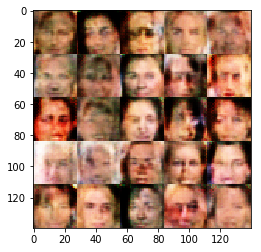

Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 2.5103
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 2.0006
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 2.2412
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 2.7280
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.6663


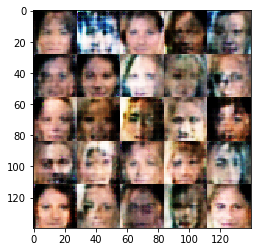

Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 2.3978
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 3.5303
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.2830


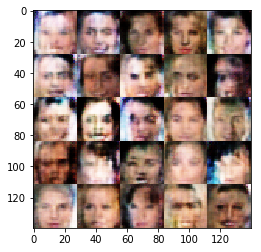

Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.4287


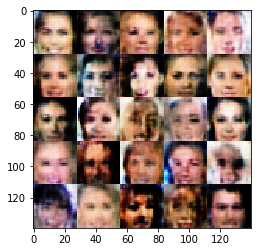

Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 3.4867
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 2.4507
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 2.9705
Epoch 1/1... Discriminator Loss: 1.9832... Generator Loss: 2.8274


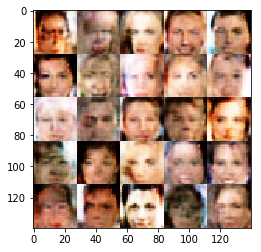

Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.6939
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 2.3352
Epoch 1/1... Discriminator Loss: 2.2733... Generator Loss: 0.1868
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 4.6966
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.7746
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 3.0136


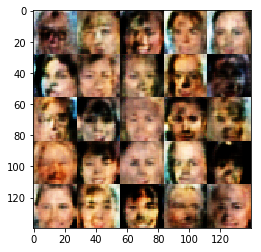

Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 1.6191
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.8087
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 4.4779
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 3.1493


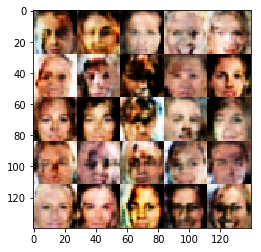

Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.3376
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 2.4969
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 3.6034
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.0719
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 3.1058
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 2.3701
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 2.3626
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.4811


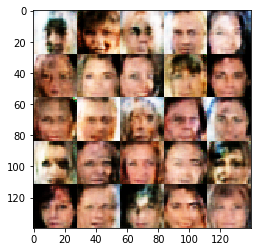

Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.6274
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 3.5349
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 2.7767
Epoch 1/1... Discriminator Loss: 2.9807... Generator Loss: 3.3875
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.3818
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.7737


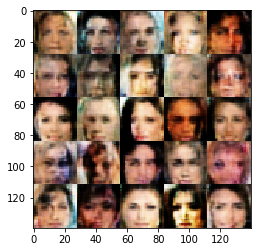

Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 2.8838
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 3.3394
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.8201
Epoch 1/1... Discriminator Loss: 2.9186... Generator Loss: 4.4201
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 2.3188
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.6423
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 2.5029


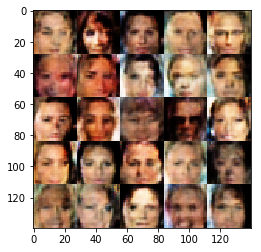

Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 2.3677
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 2.3681
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 2.2655
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 3.9526
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.7369
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.3501
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 3.4547
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.7934


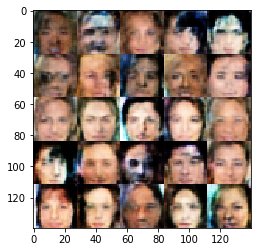

Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 2.5455
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 3.3175
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 1.8017


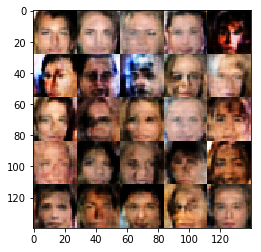

Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 2.7240
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 2.0572
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 3.2052
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6441


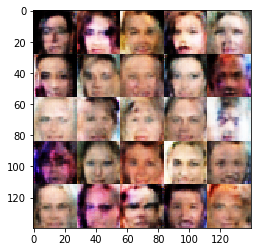

Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.3092
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.5132
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 2.4055
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.7601


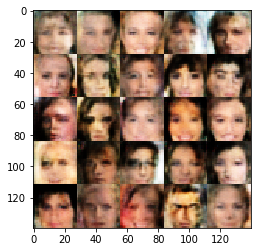

Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 3.8006
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.5462
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.9411
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.0663
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 1.7039
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.0320


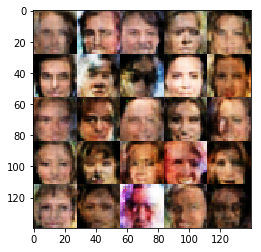

Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.4378
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 3.2269
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.8469
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.4769
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.0000


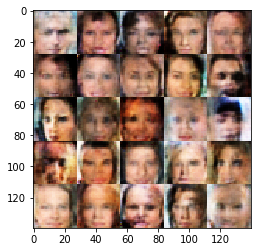

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 3.7444
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 2.0979
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.6236
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 2.0492
Epoch 1/1... Discriminator Loss: 1.7204... Generator Loss: 1.5439
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 2.1595
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 2.8305
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 4.7781


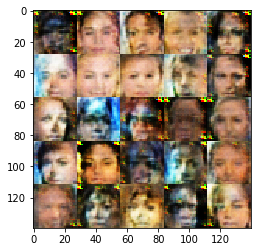

Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 6.0395
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 5.5625
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 2.8533
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 4.5781
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 3.1426
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 2.0039
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 4.9999
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.8045
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 3.1036
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.2964


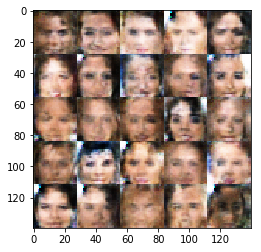

Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 2.0840
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 3.6747
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.5228
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.2789
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.4109
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 4.0150
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.8998
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6111


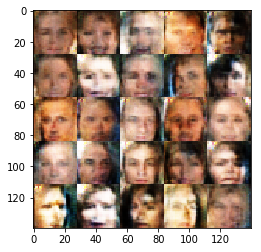

Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.6631
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 2.4623
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.3491
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 3.0982
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 3.5286
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 3.4506


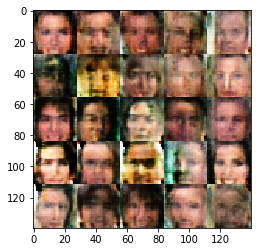

Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 2.2914
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 3.7660
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.8679
Epoch 1/1... Discriminator Loss: 2.3143... Generator Loss: 0.1846
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 2.1750
Epoch 1/1... Discriminator Loss: 1.7420... Generator Loss: 2.5828
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.4687


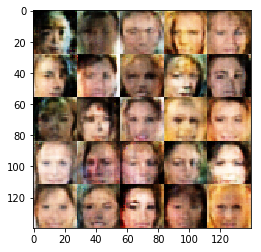

Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.5777
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.7032
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 1.6882
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 1.9560
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.6141


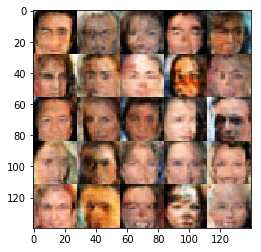

Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.7745
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.9737
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 3.4124
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.7570
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.4619
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.6481


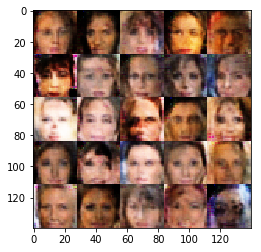

Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.4396
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.3063


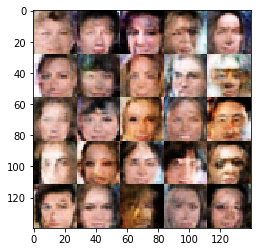

Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 1.9629
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.1497


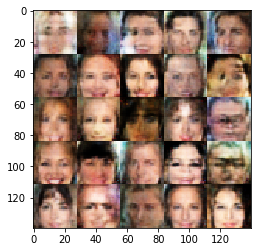

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.9521
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 2.2414... Generator Loss: 2.3646
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.9130


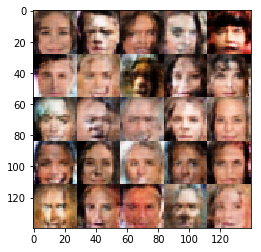

Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.4643
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.7450
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.6613
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.5925
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 1.9899... Generator Loss: 0.2541
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.2899


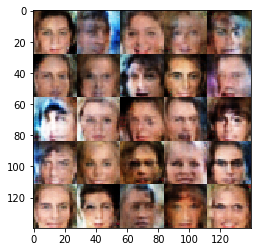

Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.7970
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.7932
Epoch 1/1... Discriminator Loss: 2.0491... Generator Loss: 0.2248


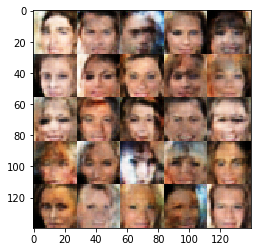

Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.4559
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6904


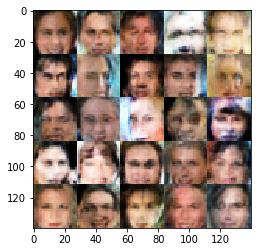

Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.5466
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.7351


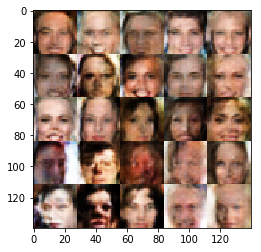

Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.8746... Generator Loss: 0.2869
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.8289


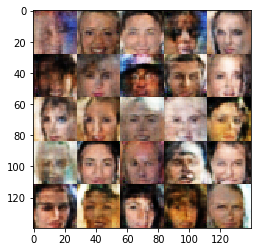

Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.6112
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.5680


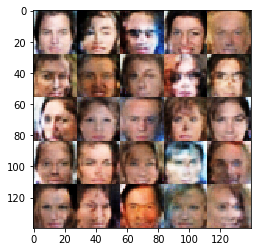

Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.4462
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.1159


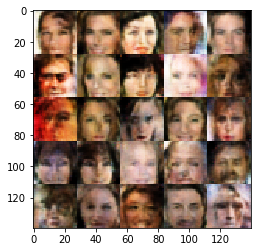

Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 2.0407
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.2396


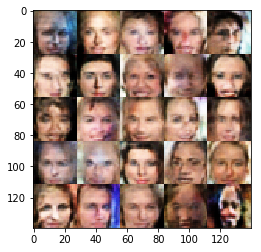

Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 1.7339... Generator Loss: 0.3185
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 2.1845
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.0373


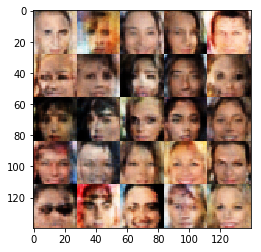

Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.8143
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.6934


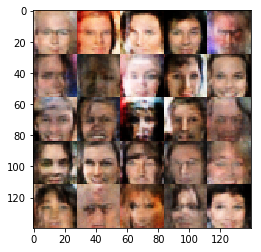

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 1.7433... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.7508
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.3140


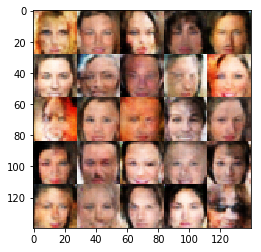

Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.5506
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.3574


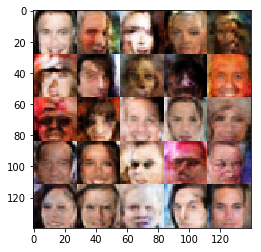

Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 2.1634
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 2.0773


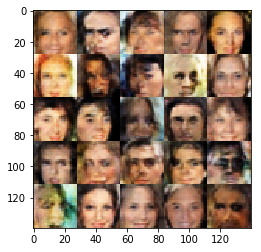

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.6939
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.8321... Generator Loss: 0.3137
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.8713
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6271


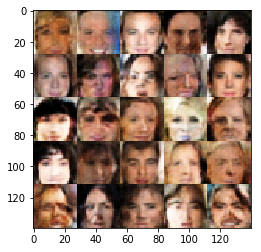

Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.5801


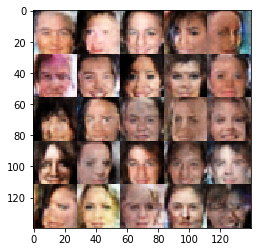

Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7974


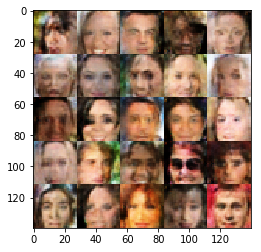

Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.4147
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.7554


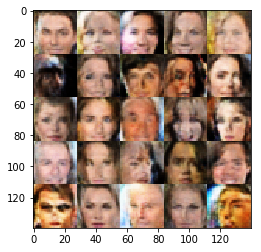

Epoch 1/1... Discriminator Loss: 1.7354... Generator Loss: 0.3118
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.9942


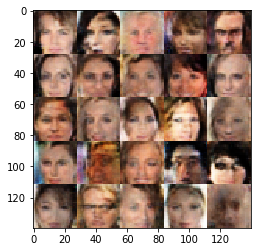

Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 2.1721
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8014


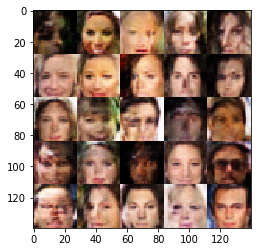

Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 2.2115
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6276


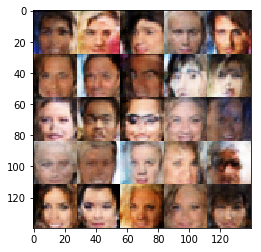

Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.7122... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.7595


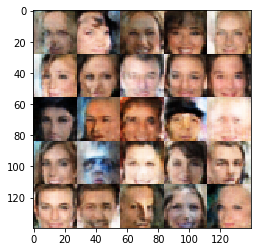

Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 2.5084
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 2.2410
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.7052... Generator Loss: 0.3526


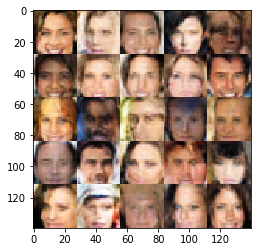

Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.3645
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.4762


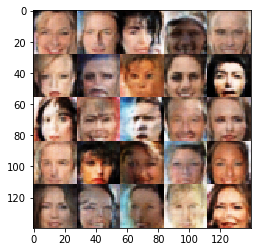

Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.3151
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.4655


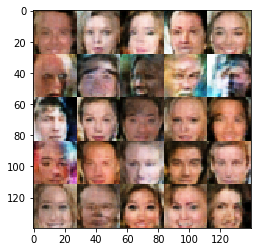

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.7486


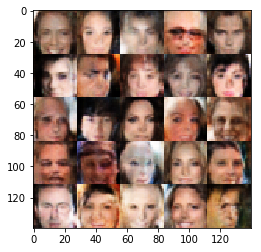

Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.3945
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 2.0079... Generator Loss: 0.2344
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 1.8886
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6871


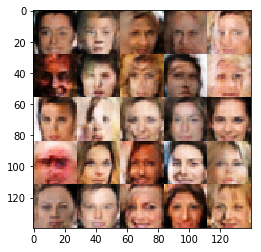

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9706


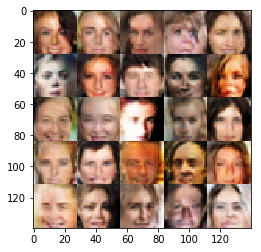

Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.1027


In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.